In [7]:
from minisom import MiniSom
from sklearn.cluster import KMeans
import seaborn as sns
import anndata as ad
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
def create_subadata(adata, markers, use, filter_for):
    channel_mask = adata.var.index.isin(markers)
    if filter_for is not None:
        cell_mask = adata.obs[use] == filter_for
    else:
        cell_mask = adata.obs[use].notna()
 
    sadata = ad.AnnData(
        X=adata.X[cell_mask, :][:, channel_mask],
        var=adata.var[channel_mask]
    )
    sadata.obs = adata.obs[cell_mask].copy()
 
    return sadata

In [ ]:
def apply_som_and_meta_clustering(adata, n_clusters=10, som_grid_size=(7, 7), n_iterations=10):
    """
    Apply SOM clustering to an AnnData object and perform meta-clustering to obtain final labels.
 
    Parameters:
    - adata: AnnData object containing the data (adata.X).
    - n_clusters: Number of final clusters (default is 10).
    - som_grid_size: Grid size for SOM (default is (7, 7)).
    - n_iterations: Number of iterations for consensus clustering (default is 10).
   
    Returns:
    - adata: AnnData object with a new 'meta_labels' column containing final cluster labels.
    """
    X_scaled = adata.X.copy()
    # Step 2: Apply SOM clustering
    som = MiniSom(som_grid_size[0], som_grid_size[1], X_scaled.shape[1], sigma=1.0, learning_rate=0.5)
    som.train_batch(X_scaled, 10000)  # Training with a batch of data
   
    # SOM cluster assignment (winner neurons)
    som_clusters = np.array([som.winner(x)[0] * som_grid_size[1] + som.winner(x)[1] for x in X_scaled])
   
    # Step 3: Meta-Clustering (Consensus Clustering) on SOM nodes
   
    # Reshape SOM clusters into a 2D array of SOM node positions (for meta-clustering)
    som_node_positions = np.array([som.winner(x) for x in X_scaled])
   
    # Consensus clustering loop (multiple iterations)
    all_meta_labels = []
    for i in range(n_iterations):
        # Fit KMeans to SOM node positions
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        kmeans.fit(som_node_positions)
       
        # The meta-clusters will now define the final labels for each cell
        meta_labels = kmeans.labels_[som_clusters]
        all_meta_labels.append(meta_labels)
   
    # Average the results over all iterations to get the final consensus labels
    final_meta_labels = np.array(all_meta_labels).mean(axis=0).astype(int)
 
    # Step 4: Add the final meta-cluster labels to the AnnData object
    adata.obs['meta_labels'] = final_meta_labels
   
    return adata
 
def plot_expression_heatmap(adata, group_variable):
    # Convert expression data to a DataFrame
    exprs_data = pd.DataFrame(adata.X, columns=adata.var.index)
    exprs_data['Cluster'] = adata.obs[group_variable].values
 
    # Group by metacluster and calculate mean expression for each marker
    mean_exprs = exprs_data.groupby('Cluster').mean()
 
    # Calculate the number of cells per cluster
    cell_counts = exprs_data['Cluster'].value_counts().sort_index()
 
    # Update the cluster labels to include cell counts
    updated_cluster_labels = [f"{cluster} (n={cell_counts[cluster]})" for cluster in mean_exprs.index]
   
    # Plot using seaborn heatmap
    plt.figure(figsize=(16, 8))
    sns.heatmap(mean_exprs, cmap='viridis', annot=True, cbar=True,
                yticklabels=updated_cluster_labels,
                annot_kws={"size": 6})
    plt.title(f'Mean Expression of Markers across {group_variable}')
    plt.xlabel('Markers')
    plt.ylabel(f'{group_variable}')
    plt.show()

In [8]:
norm_mono_data=ad.read_h5ad("PTB_drug_screen_MONO_combined_norm.h5ad")

/Users/MacBook/stanford/PTB_drug_screen/mon_venv/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [16]:
col_pheno=['115In_CD45','139La_CD66','141Pr_CD7','142Nd_CD19','143Nd_CD45RA','144Sm_CD11b','145Nd_CD4','146Nd_CD8','147Sm_CD11c','148Sm_CD123','160Gd_Tbet','162Dy_FOXP3','165Ho_CD16','169Tm_CD25','172Yb_CD62L','173Yb_CCR2','174Yb_HLADR' ,'175Lu_CD14','176Lu_CD56','198Pt_CD3']

In [18]:
norm_mono_data_pheno=norm_mono_data[:,col_pheno]

In [21]:
trained_mono=apply_som_and_meta_clustering(norm_mono_data_pheno, n_clusters=10, som_grid_size=(7, 7), n_iterations=10)

Step 2: Applying SOM clustering with grid size (7, 7)...


/var/folders/5j/l8lw0l1j2414txlrl7kh66d00000gn/T/ipykernel_96555/3185873598.py:43: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['meta_labels'] = final_meta_labels
/Users/MacBook/stanford/PTB_drug_screen/mon_venv/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Users/MacBook/stanford/PTB_drug_screen/mon_venv/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


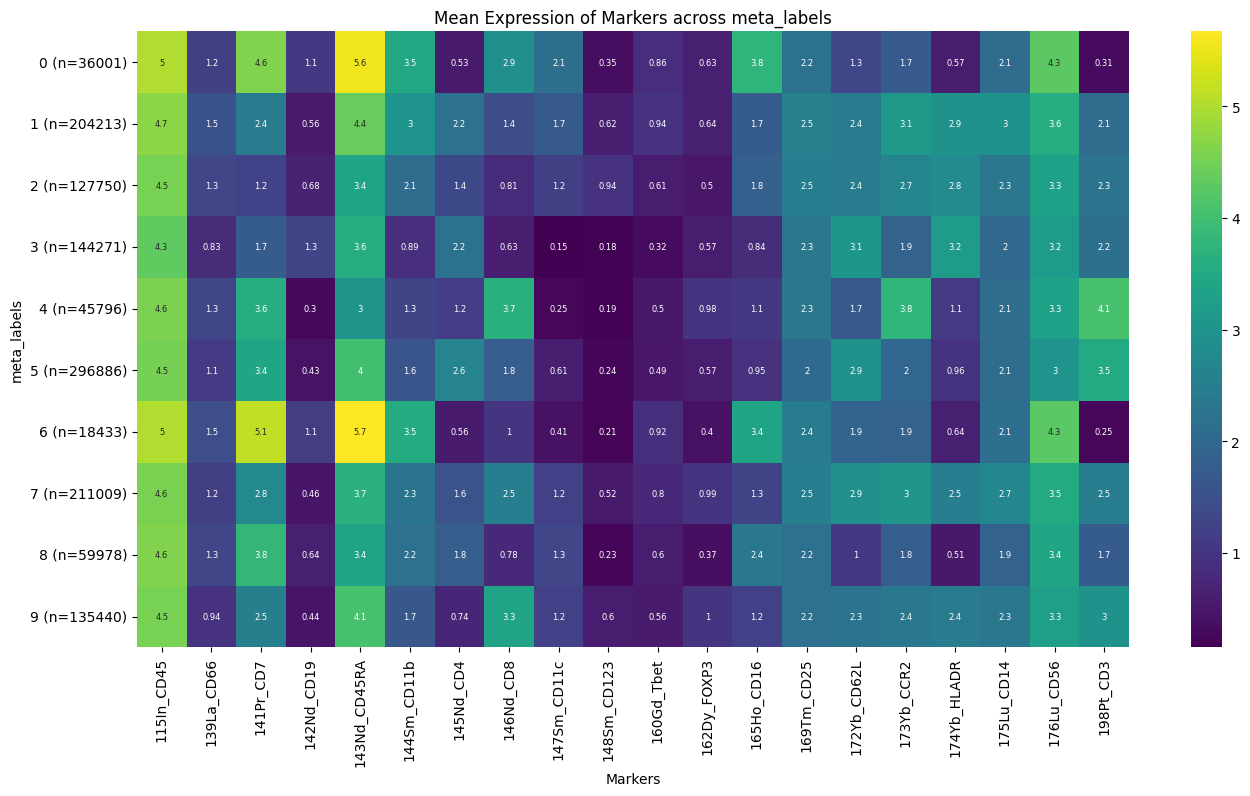

In [22]:
plot_expression_heatmap(trained_mono, 'meta_labels')